<a href="https://colab.research.google.com/github/enricsanz-dxc/sesdpw2g4/blob/main/Capacity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction for the IT department
You need to predict the CAPA_QUANTITY only
* This time use POINTTYPE=2 only (“2” stands for industry customers)
* Pls create a training set reaching from 01 Jan 2016 – 31 Dec 2018 and test set reaching from 01 Jan 2019 – 31 Dec 2019
* As prediction algorithms you should be considering multivariate linear and non-linear regression and Support Vector Machines (SVM). All these algorithms should be part of the ML tools. Otherwise, take an algorithm out of your choice.
* You need to find the best combination (= combination with best prediction quality) for all possible input factor combinations
* Pls consider that the input factors themselves need to be predicted when predicting the result for 2021.
* Prediction period: 03 June 2020 - 31.12.2021
* Pls remember you need to predict 365 days for every station (guess you have 10 stations, then your result table will be containing 3650 records)

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
! pip install -U statsmodels
# Seasonality analysis
from pylab import rcParams
import statsmodels.api as sm


Requirement already up-to-date: statsmodels in /usr/local/lib/python3.7/dist-packages (0.12.2)


In [142]:
url_quantityPrediction_quantities = 'https://github.com/enricsanz-dxc/sesdpw2g4/blob/main/files/quantityPrediction_quantities.csv?raw=true'
url_quantityPrediction_stockPrices = 'https://github.com/enricsanz-dxc/sesdpw2g4/raw/main/files/quantityPrediction_stockPrices.csv?raw=true'
url_quantityPrediction_temperatures = 'https://github.com/enricsanz-dxc/sesdpw2g4/raw/main/files/quantityPrediction_temperatures.csv?raw=true'

# Read csv files
df_qp_q = pd.read_csv(url_quantityPrediction_quantities)
df_qd_sp = pd.read_csv(url_quantityPrediction_stockPrices)
df_qs_t = pd.read_csv(url_quantityPrediction_temperatures)

# Parse Date fields
df_qd_sp['stockdate']=pd.to_datetime(df_qd_sp['stockdate'], format="%Y%m%d")
df_qp_q['BUSINESSDATE']=pd.to_datetime(df_qp_q['BUSINESSDATE'], format="%Y%m%d")
df_qs_t['tempdate']=pd.to_datetime(df_qs_t['tempdate'], format="%Y%m%d")

In [143]:
df_qs_t

,tempdate,temp_de,temp_it,temp_at,temp_pl,temp_ru,temp_ukr
0,2016-01-02,8.2,-2.1,12.2,7.0,2.6,-1.5
1,2016-01-03,6.1,-2.4,12.7,5.9,6.6,2.6
2,2016-01-04,5.5,-0.3,11.0,6.4,5.9,2.5
3,2016-01-05,4.9,1.8,10.8,3.2,6.2,3.1
4,2016-01-06,3.3,2.0,8.4,2.4,4.7,3.4
...,...,...,...,...,...,...,...
1304,2020-04-29,7.6,13.0,15.7,9.0,8.2,13.2
1305,2020-04-30,9.5,11.5,15.4,8.7,11.8,14.7
1306,2020-05-01,10.4,11.6,14.3,10.2,12.9,13.8
1307,2020-05-02,12.1,14.3,13.0,12.1,14.1,15.0


## Filter data 

Filter POINTTYPE=2

In [144]:
# Filter TYPE 1 
mask=((df_qp_q['CAPA_QUANTITY'] > 0) & (df_qp_q['PTYPE']==2) & (df_qp_q['BUSINESSDATE']>'20160101'))
df_qp_q=df_qp_q[mask]
df_qp_q=df_qp_q[df_qp_q.groupby("STATIONS")['BUSINESSDATE'].transform('size') > 1000]

In [145]:
# Extract only Date and Temperature
df_qs_t=df_qs_t.rename(columns={"tempdate": "bussinessdate"})
df_qs_t=df_qs_t.loc[:, ["bussinessdate", "temp_de","temp_it","temp_at","temp_pl"]]

# Extract only Date and Station and Quantity
df_qp_q=df_qp_q.rename(columns={"BUSINESSDATE": "bussinessdate", "CAPA_QUANTITY": "quantity", "STATIONS": "station"})
df_qp_q=df_qp_q.loc[:, ["bussinessdate", "station","quantity"]]

# Extract only ...
df_qd_sp=df_qd_sp.rename(columns={"stockdate": "bussinessdate"})
#df_qd_sp=df_qd_sp.loc[:, ["bussinessdate", "station","quantity"]]

# Merge both datasets
df = pd.merge(df_qp_q, df_qs_t, how="left", on=["bussinessdate"])
df = pd.merge(df, df_qd_sp, how="left", on=["bussinessdate"])

df['station']=pd.to_numeric(df.loc[:,'station'].str.slice(1))

In [146]:
print("\nFirst Analysis\n==============")
print("Oldest time stamp: ", df["bussinessdate"].min())
print("Most recent time stamp: ", df["bussinessdate"].max())
print("Amount of different power plant: ", df['station'].nunique())
print("Power plant data repartition:\n", df['station'].value_counts(dropna=False))
print("Lacking data any: ", df.isna().any())
print("Lacking data sum: ", df.isna().sum())


First Analysis
Oldest time stamp:  2016-01-02 00:00:00
Most recent time stamp:  2020-05-03 00:00:00
Amount of different power plant:  208
Power plant data repartition:
 1000980    1309
2000023    1309
1000122    1309
1000120    1309
1000103    1309
           ... 
1000780    1049
2000914    1035
1001111    1025
2000900    1024
2000360    1013
Name: station, Length: 208, dtype: int64
Lacking data any:  bussinessdate       False
station             False
quantity            False
temp_de             False
temp_it             False
temp_at             False
temp_pl             False
ncg                 False
powerpool           False
ttf                 False
ztp                 False
powerpool_uk_ocm    False
dtype: bool
Lacking data sum:  bussinessdate       0
station             0
quantity            0
temp_de             0
temp_it             0
temp_at             0
temp_pl             0
ncg                 0
powerpool           0
ttf                 0
ztp                 0
powerpool

In [147]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
encoder = LabelBinarizer()
encoder.fit(df['station'])
transformed = encoder.transform(df['station'])
ohe_df = pd.DataFrame(transformed)
ohe_df.columns = ['station' + "_" + str(v) for v in encoder.classes_]
dff = pd.concat([df, ohe_df], axis=1)
print(dff)
print(dff.dtypes)

       bussinessdate  station  ...  station_2000910  station_2000914
0         2018-04-22  2000800  ...                0                0
1         2018-05-03  2000800  ...                0                0
2         2018-05-04  2000800  ...                0                0
3         2018-05-05  2000800  ...                0                0
4         2018-05-24  2000800  ...                0                0
...              ...      ...  ...              ...              ...
268247    2017-09-30  2000706  ...                0                0
268248    2017-08-01  2000707  ...                0                0
268249    2017-08-02  2000707  ...                0                0
268250    2017-08-05  2000707  ...                0                0
268251    2017-08-06  2000707  ...                0                0

[268252 rows x 220 columns]
bussinessdate      datetime64[ns]
station                     int64
quantity                    int64
temp_de                   float64
temp_it

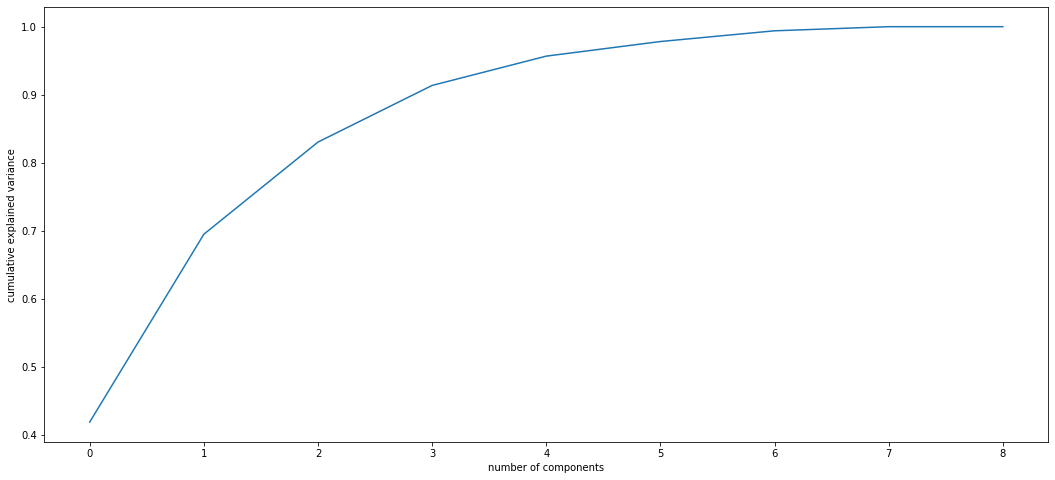

In [148]:
# 1- Standardize
features = ['ncg', 'powerpool', 'ttf', 'ztp', 'powerpool_uk_ocm',
            "temp_de","temp_it","temp_at","temp_pl"]
targets = ['quantity']
# features = features + list(ohe_df.columns)
# features = features + targets
# Separating out the features
x = dff.loc[:, features].values
# Separating out the target
y = dff.loc[:, targets].values
# Standardizing the features
X_std = StandardScaler().fit_transform(x)

pca = PCA()
X_pca = pca.fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [149]:
# Dim reduction
num_components = 9
pca = PCA(num_components)
X_pca = pca.fit_transform(X_std) # fit and reduce dimension
pca = PCA(n_components = 0.99)
X_pca = pca.fit_transform(X_std) # this will fit and reduce dimensions

print("\nHow many selected components: ", pca.n_components_) # one can print and see how many components are selected.
# print("\nMost important features: ", pca.components_)
# print("Col: ", quantity_full_frame.columns)
print("\n\n\n", pd.DataFrame(pca.components_, columns = features))


n_pcs = pca.n_components_ # get number of component
# get the index of the most important feature on EACH component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = features
# get the most important feature names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
print("\nmost_important_names: ", most_important_names)


How many selected components:  7



         ncg  powerpool       ttf  ...   temp_it   temp_at   temp_pl
0  0.194752   0.200296  0.037730  ... -0.463456 -0.458000 -0.480685
1 -0.477753  -0.564034  0.033579  ... -0.160885 -0.180913 -0.171758
2  0.079611   0.051238  0.721477  ...  0.030073  0.046498  0.020660
3  0.034217   0.053218 -0.689530  ... -0.013624 -0.008726  0.003960
4 -0.850488   0.367296  0.028993  ... -0.055736  0.046312 -0.023950
5  0.053710  -0.034647 -0.005046  ... -0.715806  0.606865 -0.178106
6  0.009555  -0.012625 -0.024257  ...  0.368579  0.612711 -0.354117

[7 rows x 9 columns]

most_important_names:  ['temp_pl', 'powerpool', 'ttf', 'ztp', 'ncg', 'temp_it', 'temp_at']




Modelisation data set
Power plant data repartition:
 2000800    1309
Name: station, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


               quantity  temp_it  temp_at  ...  powerpool    ttf    ztp
bussinessdate                              ...                         
2016-01-02     32040096     -2.1     12.2  ...       2077   2075  20801
2016-01-03     32040096     -2.4     12.7  ...       2158   2101  20802
2016-01-04     32040096     -0.3     11.0  ...       2153  21157  21266
2016-01-05     32040096      1.8     10.8  ...       2169  21231  21441
2016-01-06     32040096      2.0      8.4  ...       2181  21412  21591
...                 ...      ...      ...  ...        ...    ...    ...
2020-04-29      8164104     13.0     15.7  ...      13665  13488  13427
2020-04-30     13732104     11.5     15.4  ...      13098  12894  12949
2020-05-01     12460104     11.6     14.3  ...      12882  12894  12949
2020-05-02     12460104     14.3     13.0  ...      13031  12894  12949
2020-05-03     16300104     15.0     18.3  ...      12899  12942  13087

[1309 rows x 8 columns]
quantity       int64
temp_it      float

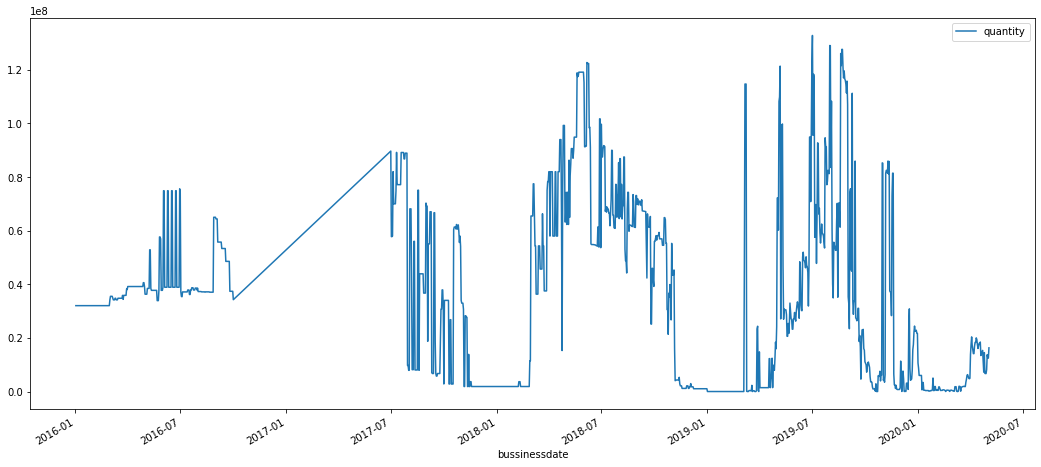

In [150]:
########################### Modelisation ###########################
# quantity_full_frame
# => Filter on STATION: L1000002 L1000026 L1000625 L1000081
# => Using features: ['temp_pl', 'powerpool', 'ttf', 'ztp', 'ncg', 'temp_it', 'temp_at', 'temp_de']
# ? powerpool_uk_ocm

# Creation of the data set
print("\n\nModelisation data set\n===============")
power_plant = 2000800

usefull_columns = most_important_names + targets + ['bussinessdate']
mask = (dff['station'] == power_plant) & (dff['quantity'] > 0)
modelisation_frame = dff[mask]
print("Power plant data repartition:\n", modelisation_frame['station'].value_counts(dropna=False))
for column_name in list(dff.columns):
    if column_name not in usefull_columns:
        modelisation_frame.pop(column_name)
modelisation_frame.set_index('bussinessdate',  inplace=True)
modelisation_frame.sort_index(inplace=True)
print(modelisation_frame)
print(modelisation_frame.dtypes)

# Plot current data
modelisation_frame[targets].plot(kind='line')
plt.show()


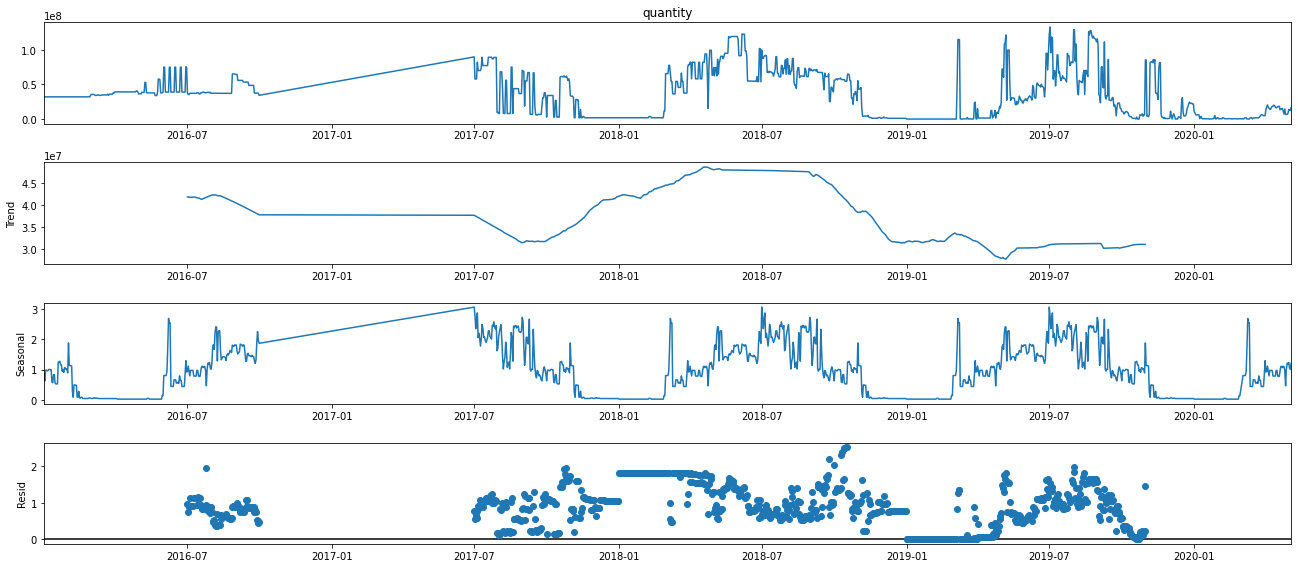

In [151]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(modelisation_frame['quantity'], model='multiplicative',period=365)
fig = decomposition.plot()
plt.show()

## Clustering stations

In [152]:
########################### Classification ###########################
# Do we have different behaviour among all these power plants
# Independently of the power orf each (division per mean)
# https://www.kaggle.com/timib1203/time-series-clustering-for-forecasting-preparation
#input_frame.replace(np.nan,0)
#print(np.isinf(input_frame.all()))
#exit()
analyzed_value='quantity'
date_column='bussinessdate'
powerplant_column='station'
input_frame=df
input_frame.reset_index()
daily_input_scaled = input_frame.pivot_table(index=date_column, columns=powerplant_column, values=analyzed_value).copy()
daily_input_scaled = daily_input_scaled.div(daily_input_scaled.mean(axis=0), axis=1).fillna(0)
print(daily_input_scaled)

station         1000002   1000013   1000026  ...   2000907   2000910   2000914
bussinessdate                                ...                              
2016-01-02     1.000032  1.146034  1.718669  ...  0.000000  0.000000  0.000000
2016-01-03     1.000032  1.146034  1.718669  ...  0.000000  0.000000  0.000000
2016-01-04     1.000032  1.146034  1.718669  ...  0.000000  0.000000  0.000000
2016-01-05     1.000032  1.146034  1.718669  ...  0.000000  0.000000  0.000000
2016-01-06     1.000032  1.146034  1.718669  ...  0.000000  0.000000  0.000000
...                 ...       ...       ...  ...       ...       ...       ...
2020-04-29     1.000032  0.902084  0.816062  ...  0.409775  1.086261  1.240115
2020-04-30     1.000032  0.902084  0.816062  ...  0.819547  1.086261  1.240115
2020-05-01     1.000032  0.902084  0.816062  ...  0.825097  1.086261  1.240115
2020-05-02     1.000032  0.902084  0.816062  ...  0.825093  1.086261  1.240115
2020-05-03     1.000032  0.902084  0.816062  ...  0.

### Normalize quantity prediction

### Implementing Agglomerative Clustering

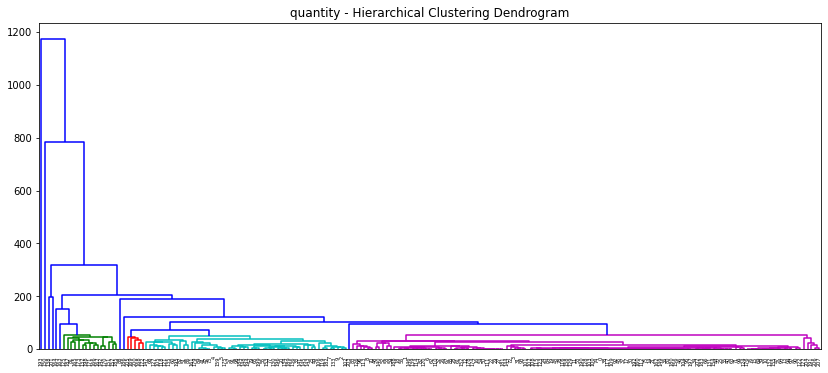

Cluster  1
Cluster size:  1
Concerned power plants:  [1000924]
Cluster  2
Cluster size:  1
Concerned power plants:  [2000861]
Cluster  3
Cluster size:  15
Concerned power plants:  [1000488, 1000780, 1000921, 1000945, 1001000, 1001030, 1001094, 1001103, 1001105, 1001118, 1001121, 1001138, 2000260, 2000380, 2000706]
Cluster  4
Cluster size:  1
Concerned power plants:  [1001072]
Cluster  5
Cluster size:  1
Concerned power plants:  [1001076]
Cluster  6
Cluster size:  5
Concerned power plants:  [1001107, 1001111, 1001123, 2000800, 2000907]
Cluster  7
Cluster size:  54
Concerned power plants:  [1000026, 1000035, 1000036, 1000042, 1000047, 1000117, 1000131, 1000226, 1000265, 1000273, 1000355, 1000361, 1000368, 1000394, 1000400, 1000411, 1000422, 1000434, 1000475, 1000483, 1000492, 1000535, 1000606, 1000618, 1000635, 1000646, 1000651, 1000652, 1000736, 1000738, 1000759, 1000814, 1000833, 1000885, 1000899, 1000915, 1000920, 1000938, 1000947, 1000955, 1000968, 1000980, 1001002, 1001034, 1001037,

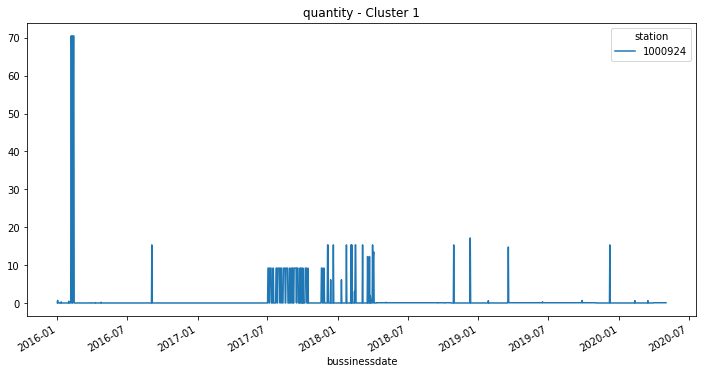

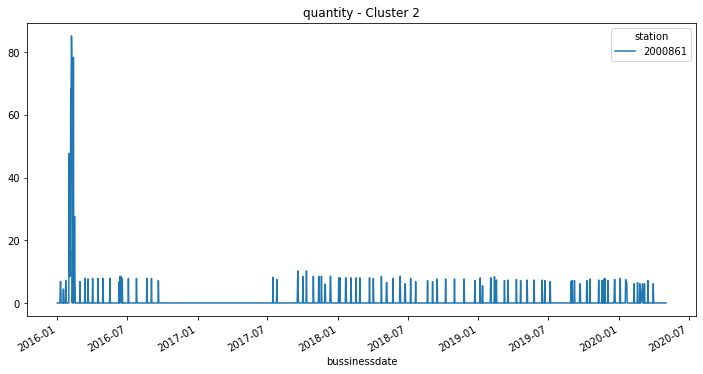

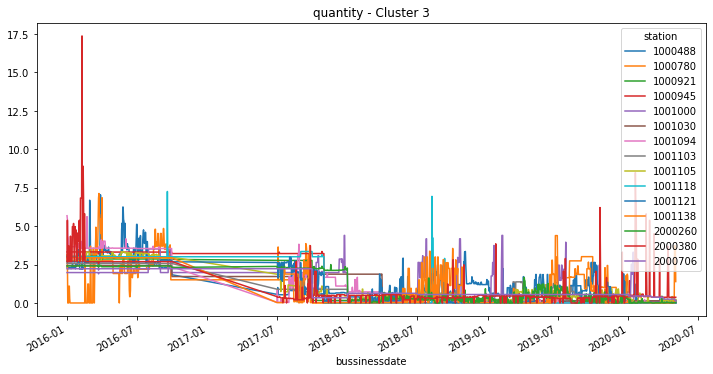

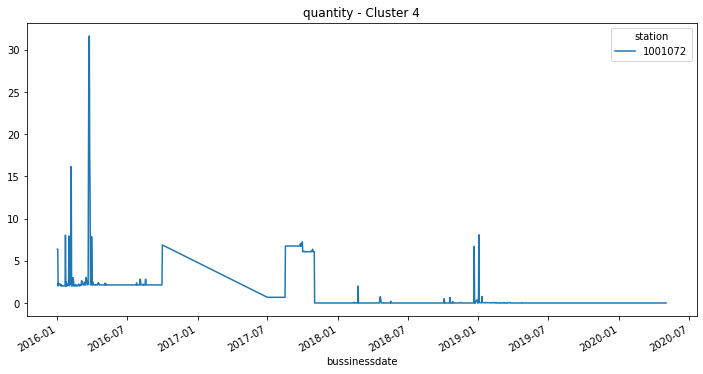

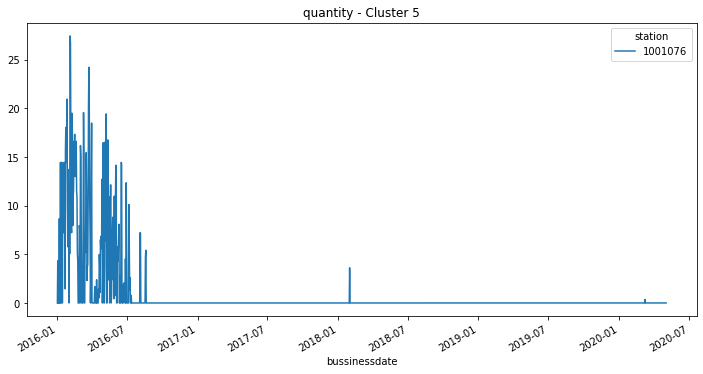

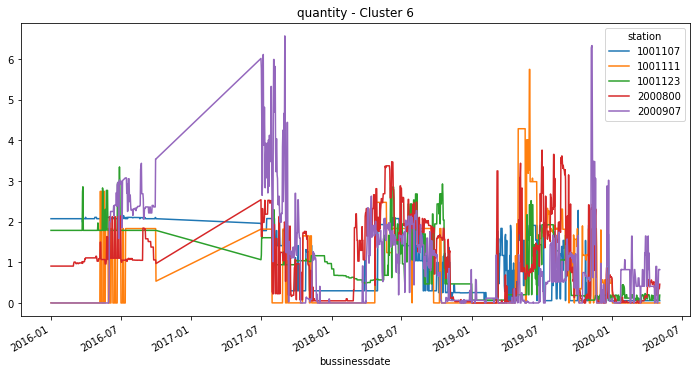

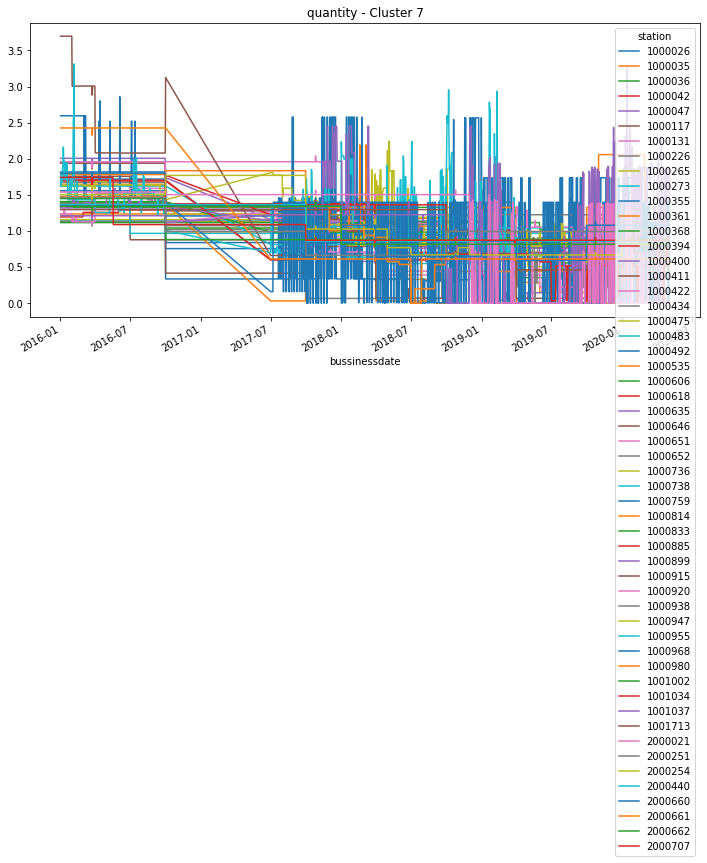

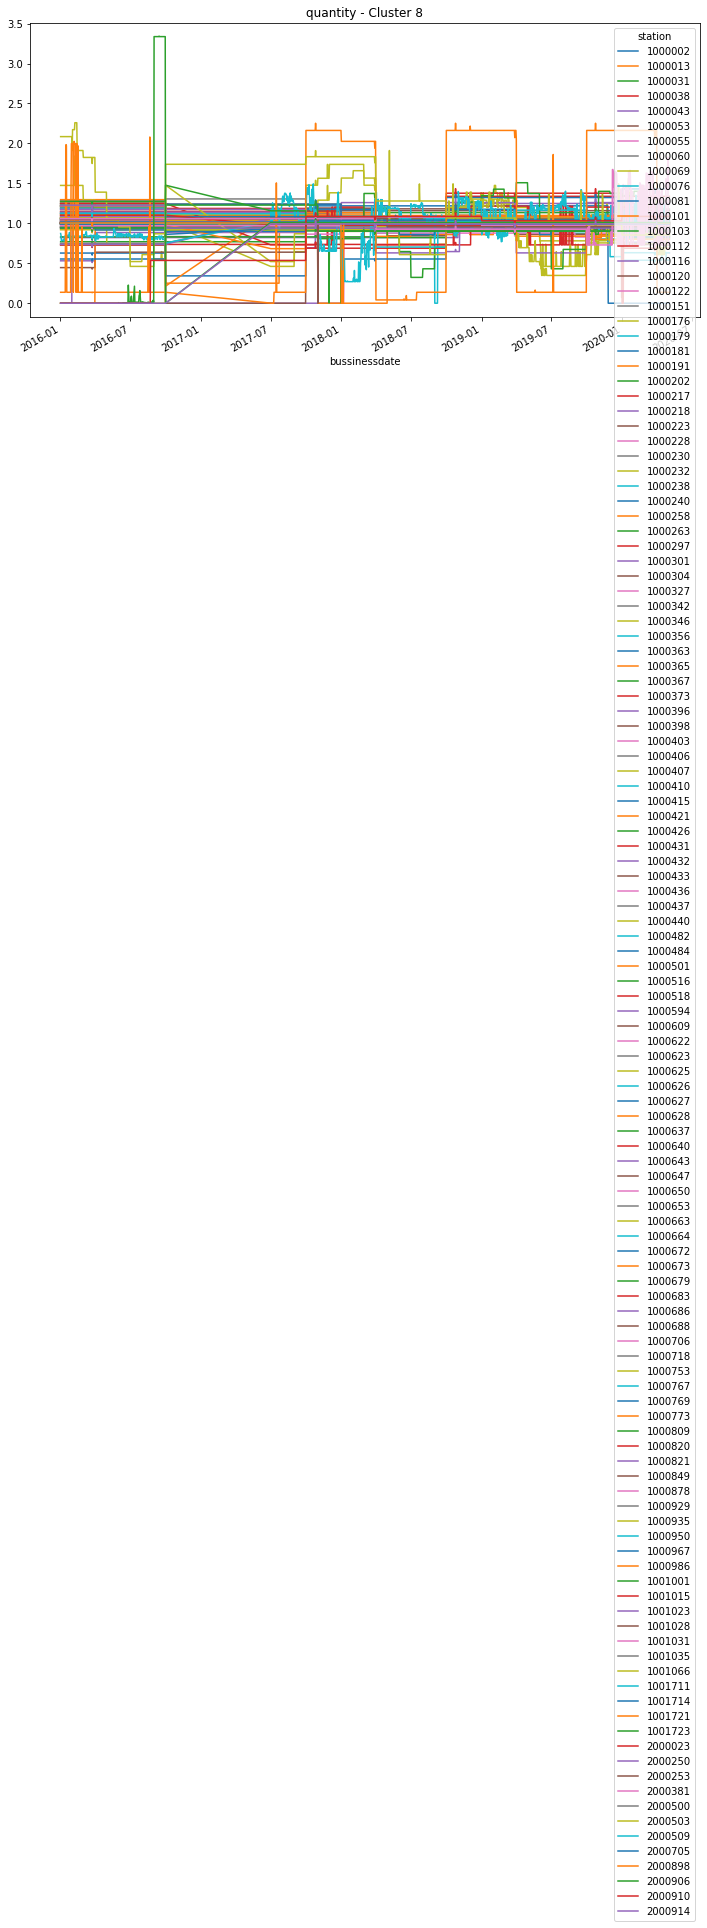

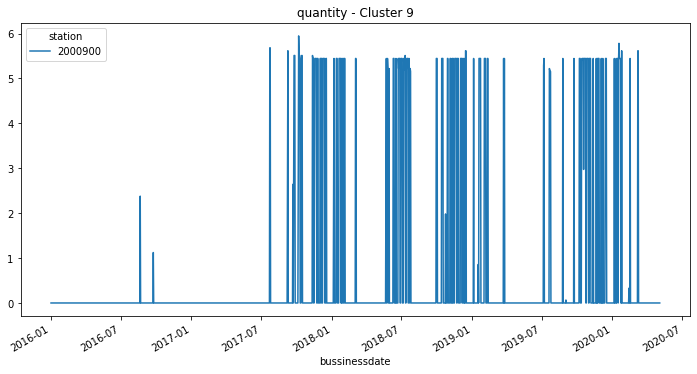

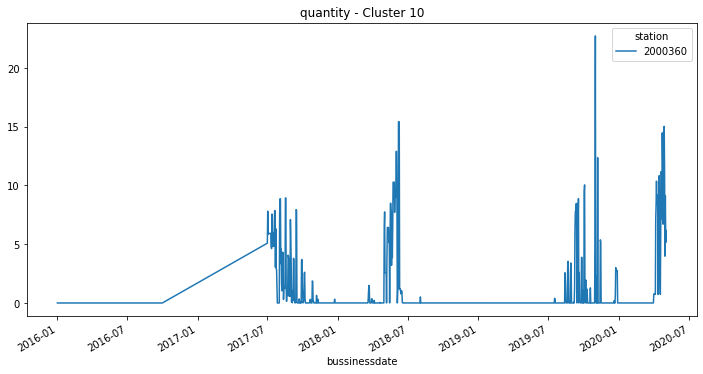

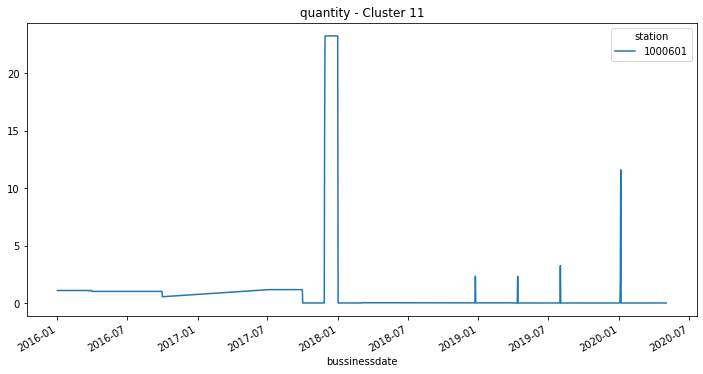

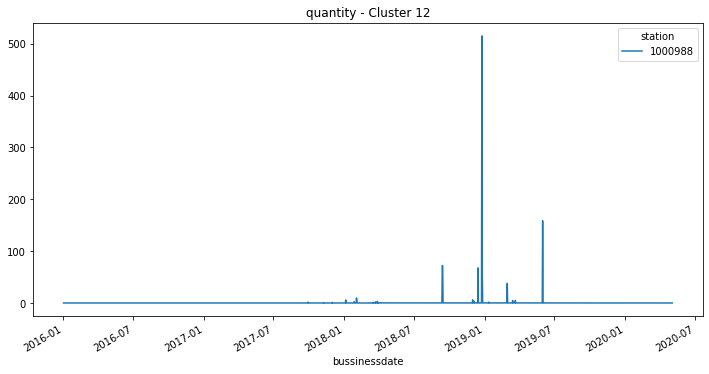

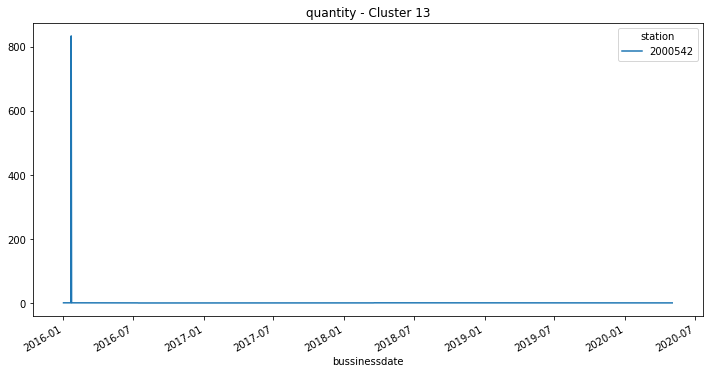

In [153]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster, ward, dendrogram

# heirarchical clustering of scales weekly item sales.
clf = AgglomerativeClustering(n_clusters=None, distance_threshold = 0).fit(daily_input_scaled.T.values)

# given a linkage model, plog dendogram, with the colors indicated by the a cutoff point at which we define clusters
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    return linkage_matrix

plt.figure(figsize = (14,6))
plt.title(analyzed_value + ' - Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
Z = plot_dendrogram(clf, p=5, color_threshold = 70)
plt.show()


# extract clusters from dendogram
clusters = fcluster(Z, 60, criterion='distance')
# print("Nbr of clusters: ", clusters.size)
# create a lookup table for series in a given cluster
daily_alloc_scaled_clustered = daily_input_scaled.T.reset_index()
daily_alloc_scaled_clustered["cluster"] = clusters
daily_alloc_scaled_clustered = daily_alloc_scaled_clustered.set_index(("cluster " + powerplant_column).split()).sort_index()

# cluster 1

# i=1 et i=4 are interesting for ALLOCATION
# i=5 and i=7 are interesting for CAPACITY
for i in range(1, clusters.size):
    try:
        if len(daily_alloc_scaled_clustered.loc[i]) > 0:
            print('Cluster ', i)
            print("Cluster size: ", len(daily_alloc_scaled_clustered.loc[i]))
            print("Concerned power plants: ",  daily_alloc_scaled_clustered.loc[i].T.columns.tolist())
            daily_alloc_scaled_clustered.loc[i].T.plot(figsize = (12,6))
            plt.title(analyzed_value + ' - Cluster ' + str(i))

    except:
        print("Cluster {} not possible".format(str(i)))

#pyplot.show()
print("Max i: ", i)


In [154]:
stations=daily_alloc_scaled_clustered.loc[6].T.columns.tolist()
print(stations)

[1001107, 1001111, 1001123, 2000800, 2000907]


In [155]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
idf=df.loc[df.station.isin(stations)].set_index('station')
mdf=idf.groupby(level=0).transform('mean')
idf['nquantity']=idf['quantity'].div(mdf['quantity'])
tdf=idf.reset_index()

/usr/local/lib/python3.7/dist-packages/pandas/core/groupby/generic.py:1475: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  fast_path = lambda group: getattr(group, func)(*args, **kwargs)


In [156]:

few_stations=stations

1001107
1001111
1001123
2000800
2000907


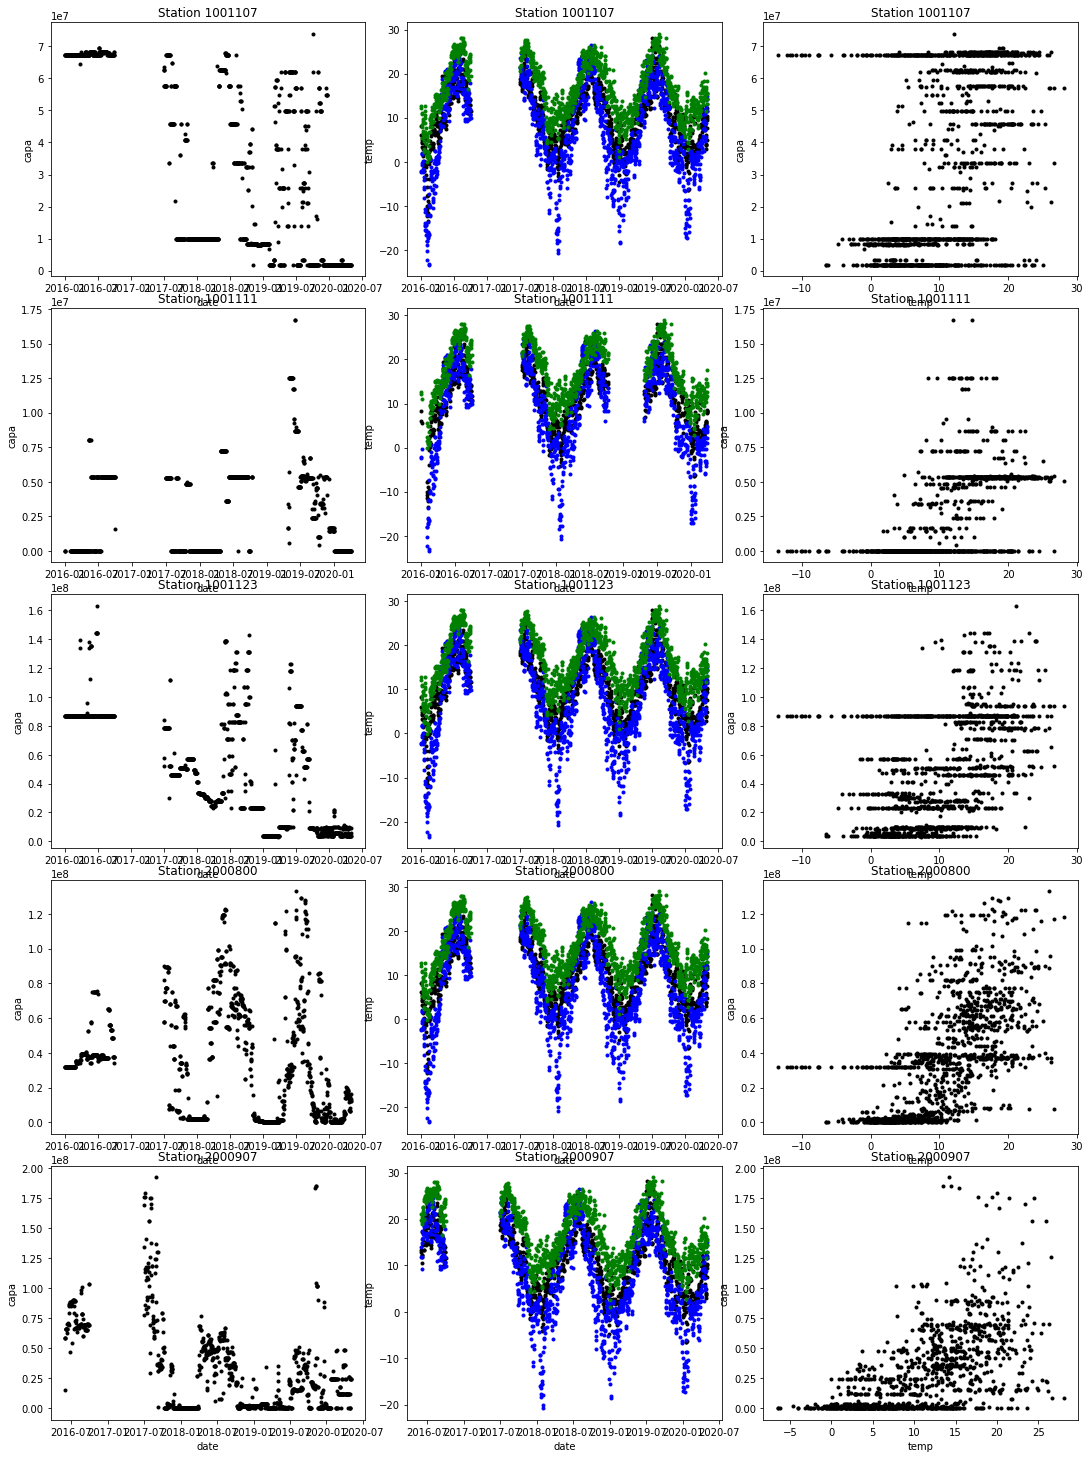

In [157]:
idf2=df.loc[df.station.isin(few_stations)].set_index('station')
# Filter only data from  01 Jan 2016 – 31 Dec 2018
tr_mask = (idf2['bussinessdate'] > '2016-01-1') & (idf2['bussinessdate'] <= '2020-06-30')
df2=idf2.loc[tr_mask,:]

#df1=df

fig, axs = plt.subplots( nrows=len(few_stations),ncols=3)
fig.set_size_inches(15,20)
fig.tight_layout() 


for i,s in enumerate(few_stations):
  #df1=df1.loc[df1['station']==s]
  print(s)
  df1=df2[df2.index==s]
  axs[i,0].plot(df1['bussinessdate'], df1['quantity'], '.', color='black');
  axs[i,0].set(title='Station %d' % s, xlabel='date', ylabel='capa')

  axs[i,1].plot(df1['bussinessdate'], df1['temp_de'], '.', color='black');
  axs[i,1].plot(df1['bussinessdate'], df1['temp_it'], '.', color='blue');
  axs[i,1].plot(df1['bussinessdate'], df1['temp_at'], '.', color='green');
  axs[i,1].title.set_text('Station %d' % s)
  axs[i,1].set(xlabel='date', ylabel='temp')

  axs[i,2].plot(df1['temp_de'], df1['quantity'], '.', color='black');
  axs[i,2].title.set_text('Station %d' % s)
  axs[i,2].set(xlabel='temp', ylabel='capa')

In [190]:
df3=tdf.groupby('bussinessdate')['quantity'].sum().reset_index().set_index('bussinessdate').asfreq('d')
df3


,quantity
bussinessdate,
2016-01-02,186382416.0
2016-01-03,186382416.0
2016-01-04,186382416.0
2016-01-05,186367416.0
2016-01-06,186367416.0
...,...
2020-04-29,31464528.0
2020-04-30,45432528.0
2020-05-01,41923032.0


In [184]:
y.info

<bound method DataFrame.info of                  quantity
bussinessdate            
2016-01-02     32040096.0
2016-01-03     32040096.0
2016-01-04     32040096.0
2016-01-05     32040096.0
2016-01-06     32040096.0
...                   ...
2020-04-29      8164104.0
2020-04-30     13732104.0
2020-05-01     12460104.0
2020-05-02     12460104.0
2020-05-03     16300104.0

[1584 rows x 1 columns]>

In [185]:
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative',period=90)
fig = decomposition.plot()
plt.show()

ValueError: ignored

In [171]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [176]:
import warnings
import itertools

warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:49971.24648104083
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:48951.667252248204
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:48092.419450421396
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:47402.15740246205
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:48015.811077560626
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:47805.11879030511
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:47513.98102702465
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:47396.21639767799
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:49052.59087648209
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:48448.73254148559
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:47385.24093504005
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:46703.44956377415
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:48414.64608740327
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:48304.97927379349
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:46854.92852303953
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:46705.36312379631
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:46692.07456946964
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:46272.66045055911
ARIMA(0

In [ ]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])